# Sampling

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Tutorial 8

Setting up the environment
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\dd}{\mathrm{d}}$
$\newcommand{\DUniform}[3]{\mathscr{U}\left(#1 ~\middle|~ #2, #3\right)}$
$\newcommand{\DNorm}[3]{\mathscr{N}\left(#1 ~\middle|~ #2, #3\right)}$


In [1]:
import math
import numpy as np
from scipy.stats import uniform, multivariate_normal
import matplotlib.pyplot as plt

%matplotlib inline

The aim of this tutorial is to investigate the effects of different proposal distributions on importance sampling.

## Sampling from Gaussian and Uniform Distributions

*Note that help for a certain function can be obtained by using the question mark, for example * ```?uniform``` or ```?norm```.

Repeat the following twice, once each for Gaussian with zero mean and unit variance and Uniform on the unit square.
1. Sample 1000 data points from a two dimensional distribution.
2. Compute the [two dimensional histogram](http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html), with 10 bins in each dimension.
3. Visualise the histogram as a heatmap. There are [various ways of doing this](http://thomas-cokelaer.info/blog/2014/05/matplotlib-difference-between-pcolor-pcolormesh-and-imshow/) as a two dimensional image. Use an [appropriate colormap](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/).
4. Visualise the difference between the theoretical and empirical values of the density.

The aim of this exercise is to observe the challenges of sampling in more than 1 dimension.

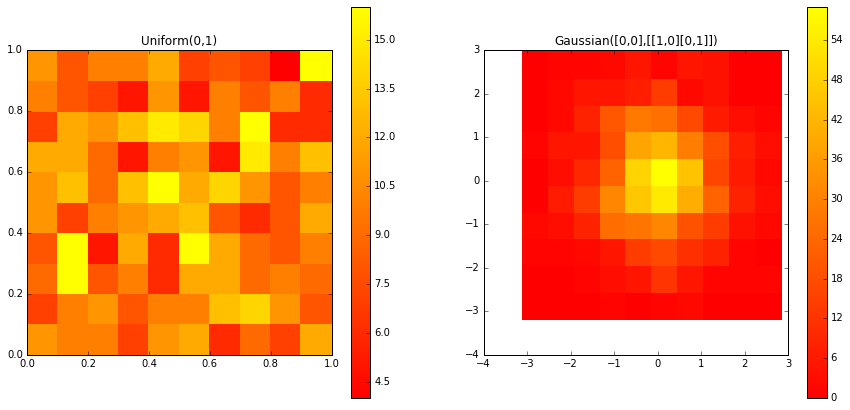

In [2]:
# Solution

N = 1000
rv = uniform()
x = rv.rvs(N)
y = rv.rvs(N)
H, xedges, yedges = np.histogram2d(x,y)
X, Y = np.meshgrid(xedges, yedges)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
p1 = ax.pcolormesh(X, Y, H, cmap='autumn')
ax.set_aspect('equal')
ax.set_title('Uniform(0,1)')
plt.colorbar(p1)

rv = multivariate_normal(mean=[0,0], cov=np.eye(2))
Z = rv.rvs(N)
x = Z[:,0]
y = Z[:,1]
H, xedges, yedges = np.histogram2d(x,y)
X, Y = np.meshgrid(xedges, yedges)
ax = fig.add_subplot(122)
p1 = ax.pcolormesh(X, Y, H, cmap='autumn')
ax.set_aspect('equal')
ax.set_title('Gaussian([0,0],[[1,0][0,1]])')
plt.colorbar(p1)


## A function for performing estimation

Given are the following function $f(x, y)$

\begin{equation*}
  f(x, y) = x \,  y  \cos(x) \, \cos(y),
\end{equation*}

and the (unnormalised!) distribution $ \widetilde{p}(x, y) $
\begin{equation*}
  \widetilde{p}(x, y) = 
                 \exp \left\{- \frac{1}{4}((x - 2)^2 + (y - 3)^2) \right\}
    - \frac{3}{4} \exp \left\{- \frac{1}{2} ((x - 2)^2 + (y - 3)^2) \right\}
\end{equation*}

The goal is to numerically estimate $ \Ex[p(x, y)]{f(x, y)} $ defined as
\begin{equation*}
   \Ex[p(x, y)]{f(x, y)} = \int_{-\infty}^{\infty} f(x, y) \, p(x, y) \dd x \dd y
\end{equation*}

where $ p(x, y) $ is the normalised probability distribution derived from $\widetilde{p}(x, y) $
\begin{equation*}
   p(x, y) = \frac{ \widetilde{p}(x, y) }
                  { \int_{-\infty}^{\infty}  \int_{-\infty}^{\infty} \widetilde{p}(x, y) \dd x \dd y }
\end{equation*}

Note, that with importance sampling, this can be achieved without calculating the normalisation. All we need to do, is to use sample points from an appropriate distribution $ \widetilde{q}(x, y) $ 
which has most of its probability mass in regions where $ \widetilde{p}(x, y) $ is also nonzero.

In the following, we will implement importance sampling to estimate $ \Ex[p(x, y)]{f(x, y)} $ for two choices of $ \widetilde{q}(x, y) $, a Uniform
Distribution and a Gaussian Distribution.

**(optional) Plot the functions $f(x,y)$ and $\widetilde{p}(x, y)$. Look at the 3D plotting section in [this tutorial](\widetilde{p}(x, y)).**

In [3]:
# Solution

sigma1 = 2.0
sigma2 = 1.0

def f(x, y):
    return x * y * math.cos(x) * math.cos(y)

def p(x, y):
    return math.exp(- 1.0/(2.0*sigma1) * ((x - 2)**2 + (y - 3)**2)) \
    - 3.0/4.0 * math.exp(- 1.0/(2.0*sigma2) * ((x - 2)**2 + (y - 3)**2))
   

## Importance Sampling using the Uniform Distribution

Draw random samples $ x_n $ and $ y_n $, $ n = 1, \dots, N $, 
each from the uniform distribution $ \DUniform{\cdot}{-10}{20} $. That means
$ \widetilde{q}(x, y) = \DUniform{x}{-10}{20} \, \DUniform{y}{-10}{20} $.

Now use the samples from the distribution $ \widetilde{q}(x, y) $ to estimate 
$ \Ex[p(x, y)]{f(x, y)} $ via importance sampling.



In [4]:
# Solution

def importance_uniform(num_points=100, batch_size=1000):
    """Compute the expectation of f(x,y) over the unormalised distribution p(x,y).
    Uses the uniform(-10,30) as a proposal distribution.
    """
    exp_f = 0
    denom = 0
            
    N      = num_points * batch_size
    result = np.empty((num_points,))
    k = 0
    rv_x = uniform(loc=-10, scale=30)
    rv_y = uniform(loc=-10, scale=30)
    for ix in range(N):
        x = rv_x.rvs()
        y = rv_y.rvs()
        pval = p(x, y)
        qval = rv_x.pdf(x)*rv_y.pdf(y)
        
        exp_f  += f(x, y) * pval/qval
        denom += pval/qval 
        
        if ix % batch_size == 0:
            result[k] = exp_f/denom
            k += 1
    return result

est_uniform = importance_uniform()

## Importance Sampling using the Gaussian Distribution

create random vectors from the following Gaussian Distribution
$ \widetilde{q}(x, y) = \DNorm{(x, y)^T}{\mathbf{\mu} = (2, 3)^T}{\mathbf{\Sigma} = \begin{bmatrix} 2 & 0 \\ 0 & 3 \\ \end{bmatrix}} $.

Now use the samples from the distribution $ \widetilde{q}(x, y) $ to estimate 
$ \Ex[p(x, y)]{f(x, y)} $ via importance sampling.



In [5]:
# Solution

def importance_gaussian(num_points=100, batch_size=1000):
    """Compute the expectation of f(x,y) over the unormalised distribution p(x,y).
    Uses Normal([2,3], [[2,0][[0,3]]]) as a proposal distribution.
    """
    exp_f = 0
    denom = 0
            
    N      = num_points * batch_size
    result = np.empty((num_points,))
    k = 0
    rv = multivariate_normal(mean=np.array([2,3]), cov=np.array([[2,0],[0,3]]))
    for ix in range(N):
        x,y = rv.rvs()
        pval = p(x, y)
        qval = rv.pdf([x,y])
        
        exp_f  += f(x, y) * pval/qval
        denom += pval/qval 
        
        if ix % batch_size == 0:
            result[k] = exp_f/denom
            k += 1
    return result

est_gaussian = importance_gaussian()

## Comparing the empirical and analytic results

For the function $f(x, y)$ and the normalised distribution $p(x, y)$,
the correct result can be computed analytically
\begin{align*}
    \Ex[p(x, y)]{f(x, y)} 
    & = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x, y) \, p(x, y) 
                \dd x \dd y \\
    & =   \frac{16 (5 \cos(1) + \cos(5) + \sin(1) - 5 \sin(5))
      - 3 e (7 \cos(1) + 5 \cos(5) + \sin(1) - 5 \sin(5)) }
               {10 \, e^2} \\                      
    & \approx 0.670859
\end{align*}

Compare the convergence rate of the two approaches given above. Plot on the same plot the two curves showing the empirical expectation as a function of the number of samples as well as the analytical value.


(-1, 4)

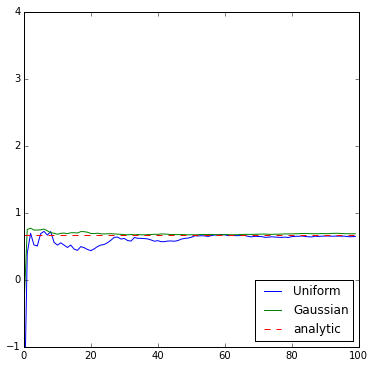

In [6]:
# Solution

num_points = len(est_uniform)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(range(num_points), est_uniform, label='Uniform')
ax.plot(range(num_points), est_gaussian, label='Gaussian')
ax.plot([0, num_points], [0.670859, 0.670859], 'r--', label='analytic')
ax.legend(loc='lower right')
ax.set_ylim([-1,4])

Discuss how one could choose an appropriate proposal distribution for a particular function $f(x,y)$ and distribution $p(x,y)$.

### Solution